# 1. Overview

# 2. Data understanding

## 2.1 Data description

## 2.2 Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2.3 Functions

In [2]:
def identify_product(tweet_text):
    """
    Identify if the tweet is about a Google or Apple product, and replace any product-related keywords
    with 'tecproduct'.
    
    Parameters:
    tweet_text (str): The text of the tweet.
    
    Returns:
    str: 'Google' if the tweet mentions a Google product, 'Apple' if the tweet mentions an Apple product,
         'Both' if the tweet mentions both, 'Unknown' if it mentions neither.
    """
    google_keywords = ['google', 'pixel', 'pixels', 'nexus', 'nexuses', 'android', 'androids', 
                       'chromebook', 'chromebooks', 'nest', 'nests', 'stadia', 'stadias']
    apple_keywords = ['apple', 'apples', 'iphone', 'iphones', 'ipad', 'ipads', 'macbook', 
                      'macbooks', 'imac', 'imacs', 'watch', 'watches', 'airpods', 
                      'appstore', 'ios', 'itunes']
    
    # Ensure tweet_text is a string
    if not isinstance(tweet_text, str):
        return 'Unknown'
    
    # Replace "app store" with "appstore" before tokenization
    tweet_text = tweet_text.replace("app store", "appstore")
    
    # Replace any occurrences of google_keywords and apple_keywords with 'tecproduct'
    for keyword in google_keywords + apple_keywords:
        tweet_text = re.sub(rf'\b{keyword}\b', 'tecproduct', tweet_text, flags=re.IGNORECASE)
    
    return tweet_text


In [3]:
# Define the function to clean and preprocess tweets
def clean_text(text):
    if not isinstance(text, str):
        return text
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove strange characters and punctuation
    strange_chars = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#Ûª'
    text = text.translate(str.maketrans(strange_chars, ' ' * len(strange_chars)))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text


In [4]:
def preprocess_product_mention(df):
    df['product_mention'] = df['product_mention'].astype(str)
    return df

# 3. Code

## 3.1 Import the database

In [5]:
# Load and prepare data
df = pd.read_csv('df.csv')
df['cleaned_text'] = df['tweet_text'].apply(identify_product)

df

,tweet_text,emotion_type,product_mention,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,Apple,.@wesley83 I have a 3G tecproduct. After 3 hrs...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,Apple,@jessedee Know about @fludapp ? Awesome tecpro...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,Apple,@swonderlin Can not wait for #tecproduct 2 als...
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,Apple,@sxsw I hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,Google,@sxtxstate great stuff on Fri #SXSW: Marissa M...
...,...,...,...,...
7928,Ipad everywhere. #SXSW {link},Positive emotion,Apple,tecproduct everywhere. #SXSW {link}
7929,"Wave, buzz... RT @mention We interrupt your re...",unknown,Google,"Wave, buzz... RT @mention We interrupt your re..."
7930,"Google's Zeiger, a physician never reported po...",unknown,Google,"tecproduct's Zeiger, a physician never reporte..."
7931,Some Verizon iPhone customers complained their...,unknown,Apple,Some Verizon tecproduct customers complained t...


In [ ]:
# Apply cleaning
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
# Preparar características y etiquetas
texts = df['cleaned_text']
product_mentions = df['product_mention']
labels = df['emotion_type']

# Crear un DataFrame para las características
X = pd.DataFrame({
    'text': texts,
    'product': product_mentions
})

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Preprocesar el texto (limitando a las 2000 palabras más importantes)
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_train_text = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_text = tfidf_vectorizer.transform(X_test['text'])

# Preprocesar la columna categórica
onehot_encoder = OneHotEncoder(sparse=False)
X_train_product = onehot_encoder.fit_transform(X_train[['product']])
X_test_product = onehot_encoder.transform(X_test[['product']])

# Concatenar las características procesadas
X_train_processed = np.hstack([X_train_text.toarray()])
X_test_processed = np.hstack([X_test_text.toarray()])

# Crear y ajustar el modelo
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Realizar la búsqueda en malla con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_processed, y_train)

# Evaluar el modelo en los datos de prueba
y_pred = grid_search.predict(X_test_processed)
print(classification_report(y_test, y_pred))

C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


                  precision    recall  f1-score   support

Negative emotion       0.68      0.22      0.33        95
Positive emotion       0.69      0.45      0.55       609
         unknown       0.66      0.86      0.75       883

        accuracy                           0.67      1587
       macro avg       0.67      0.51      0.54      1587
    weighted avg       0.67      0.67      0.65      1587



      Feature  Importance
1006     link    0.016384
909      ipad    0.015454
757     great    0.013219
747    google    0.010689
120   awesome    0.010104
1460       rt    0.010039
74        app    0.009676
77      apple    0.009364
371      cool    0.008620
1662    store    0.008262
1166      new    0.006650
911    iphone    0.006466
744      good    0.006370
1173     nice    0.005981
55        amp    0.005945
1037     love    0.005859
109    austin    0.005383
1384     quot    0.005120
1703     sxsw    0.004664
1310      pop    0.004662


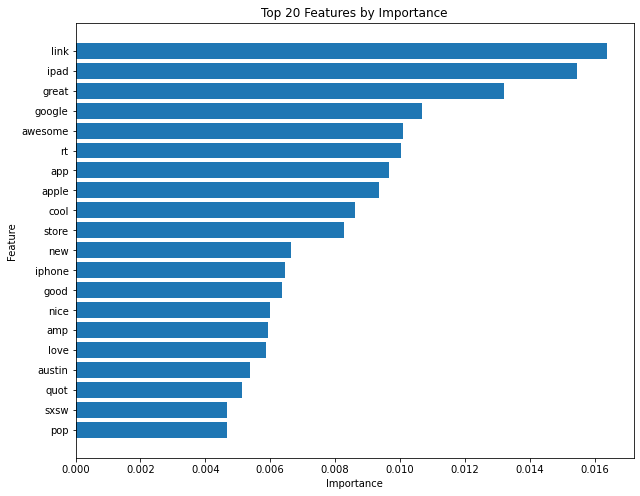

In [13]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Obtener las importancias de las características
feature_importances = best_model.feature_importances_

# Obtener los nombres de las características
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names])

# Crear un DataFrame con las importancias de las características
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importance_df.head(20))

# Graficar las importancias de las características
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Ajustar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_

# Obtener la importancia de características global
global_feature_importances = best_model.feature_importances_

# Inicializar una lista para almacenar la importancia por clasez
class_feature_importances = []

# Obtener la importancia de características por clase
for class_index in range(len(best_model.classes_)):
    class_importance = np.zeros_like(global_feature_importances)
    
    for tree in best_model.estimators_:
        # Obtener la probabilidad predicha por este árbol para la clase actual
        tree_class_prob = tree.predict_proba(X_train_processed)[:, class_index]
        
        # Multiplicar la importancia de características por la probabilidad de clase
        class_importance += tree.feature_importances_ * tree_class_prob.sum()

    # Normalizar la importancia para la clase
    class_importance /= class_importance.sum()
    class_feature_importances.append(class_importance)

# Mostrar las 10 características más importantes para cada clase
for class_index, class_name in enumerate(best_model.classes_):
    print(f"\nTop 10 características más importantes para la clase '{class_name}':")
    sorted_indices = np.argsort(class_feature_importances[class_index])[::-1]
    for i in sorted_indices[:10]:
        print(f"{feature_names[i]}: {class_feature_importances[class_index][i]:.4f}")


Top 10 características más importantes para la clase 'Negative emotion':
link: 0.0164
ipad: 0.0154
great: 0.0132
google: 0.0107
awesome: 0.0101
rt: 0.0100
app: 0.0097
apple: 0.0094
cool: 0.0086
store: 0.0082

Top 10 características más importantes para la clase 'Positive emotion':
link: 0.0164
ipad: 0.0155
great: 0.0132
google: 0.0107
awesome: 0.0101
rt: 0.0100
app: 0.0097
apple: 0.0094
cool: 0.0086
store: 0.0083

Top 10 características más importantes para la clase 'unknown':
link: 0.0164
ipad: 0.0155
great: 0.0132
google: 0.0107
awesome: 0.0101
rt: 0.0100
app: 0.0097
apple: 0.0094
cool: 0.0086
store: 0.0083


In [5]:
# Apply cleaning
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

# Prepare features and labels
texts = df['cleaned_text']
product_mentions = df['product_mention']
labels = df['emotion_type']

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Define preprocessing for text and product mention
text_preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, max_df=0.7, min_df=5))
])

product_mention_preprocessor = Pipeline([
    ('preprocessor', FunctionTransformer(preprocess_product_mention, validate=False)),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Create Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cleaned_text', text_preprocessor, 'cleaned_text'),
        ('product_mention', product_mention_preprocessor, 'product_mention')
    ]
)

# Define models
def build_lstm_model(epochs=10):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bidirectional_lstm_model(epochs=10):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm_model(epochs=10):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_deep_nn_model(epochs=10):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# XGBoost model
def build_xgboost_model():
    return XGBClassifier(eval_metric='mlogloss')

# Create a pipeline with preprocessing and model
def create_pipeline(model_func, **kwargs):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_func(**kwargs))
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[['cleaned_text', 'product_mention']], labels_categorical, test_size=0.2, random_state=42)

# Define parameter grids for tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1]
    },
    'LSTM': {'classifier__epochs': [5, 10, 15]},
    'Bidirectional LSTM': {'classifier__epochs': [5, 10, 15]},
    'CNN + LSTM': {'classifier__epochs': [5, 10, 15]},
    'Deep NN': {'classifier__epochs': [5, 10, 15]}
}

In [6]:
# Define models
model_funcs = {
    'Logistic Regression': lambda: LogisticRegression(max_iter=1000),
    'Random Forest': lambda: RandomForestClassifier(),
    'XGBoost': build_xgboost_model,
    'LSTM': build_lstm_model,
    'Bidirectional LSTM': build_bidirectional_lstm_model,
    'CNN + LSTM': build_cnn_lstm_model,
    'Deep NN': build_deep_nn_model
}

# Create and tune models
results = {}

for name, model_func in model_funcs.items():
    print(f"\nTuning model: {name}")
    if name in ['LSTM', 'Bidirectional LSTM', 'CNN + LSTM', 'Deep NN']:
        pipeline = create_pipeline(model_func, epochs=10)
    else:
        pipeline = create_pipeline(model_func)
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1) if name not in ['XGBoost'] else y_pred
    y_true_classes = np.argmax(y_test, axis=1)
    accuracy = grid_search.best_score_
    results[name] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'y_pred': y_pred,
        'classification_report': classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_),
        'confusion_matrix': confusion_matrix(y_true_classes, y_pred_classes)
    }
    print(f"\n{name} Best Parameters: {grid_search.best_params_}")
    print(f"{name} Best Accuracy: {accuracy:.4f}")

    # Print Classification Report
    print(f"\n{name} Classification Report:")
    print(results[name]['classification_report'])

    # Print Confusion Matrix
    print(f"\n{name} Confusion Matrix:")
    cm = results[name]['confusion_matrix']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# Compare results
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest Model: {best_model_name} with Accuracy: {results[best_model_name]['accuracy']:.4f}")


Tuning model: Logistic Regression


ValueError: 
All the 9 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 98, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index_class_helper.pxi", line 93, in pandas._libs.index.Int64Engine._check_type
KeyError: 'product_mention'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py", line 754, in fit_transform
    result = self._fit_transform(X, y, _fit_transform_one)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py", line 681, in _fit_transform
    return Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 471, in fit_transform
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_function_transformer.py", line 240, in transform
    return self._transform(X, func=self.func, kw_args=self.kw_args)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_function_transformer.py", line 312, in _transform
    return func(X, **(kw_args if kw_args else {}))
  File "<ipython-input-3-be33faf0ed4d>", line 2, in preprocess_product_mention
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py", line 882, in __getitem__
    return self._get_value(key)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py", line 989, in _get_value
    loc = self.index.get_loc(label)
  File "C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexes\base.py", line 2897, in get_loc
    raise KeyError(key) from err
KeyError: 'product_mention'
